In [1]:
if True:
    import time
    import torch
    import numpy as np
    import matplotlib.pyplot as plt
    from typing import Callable, Type
    from IPython.display import clear_output, display

    torch.manual_seed(42)

    %matplotlib inline
    def train(
            model: torch.nn.Module,
            X: torch.Tensor, 
            Y: torch.Tensor,
            loss_function: Callable = torch.nn.MSELoss(), 
            optimizer_class: Type = torch.optim.SGD,
            epochs: int = 200,
            learning_rate: float = 0.01,
            sleep_time: int | None = None,
            early_stopping_threshold: float = 0.002,
            viz_every: int = 1
            ) -> torch.nn.Module:
        
        optimizer = optimizer_class(model.parameters(), lr=learning_rate)
        losses = []
        
        for epoch in range(epochs+1):

            # Do a train step
            # # Everything else is just 'fluff'
            optimizer.zero_grad()
            Y_pred = model(X)
            loss = loss_function(Y_pred, Y)
            loss.backward()
            optimizer.step()
            
            # Visuzlie every n times
            if epoch % viz_every == 0 and model.layers[0].in_features == 1:
                # Live visualization
                clear_output(wait=True)
                plt.figure(figsize=(6,4), dpi=100)

                # Plot real data
                plt.scatter(X.numpy(), Y.numpy(), alpha=0.3, label='Data')
                # Plot model predictions
                with torch.no_grad():
                    X_pred = model(X)
                plt.plot(X.numpy(), Y_pred.detach().numpy(), 'r-', label='Model Prediction')

                plt.title(f"Epoch: {epoch}, Loss={loss.item():.4f}")
                plt.legend()
                plt.show()

            if epoch % viz_every == 0 and model.layers[0].in_features == 2:
                # clear_output(wait=True)
                # fig, ax = plt.subplots(figsize=(6, 6), dpi=100)

                # # Scatter your training data
                # plt.scatter(X[:,0], X[:,1], c=Y, alpha=0.8)

                # # Generate a grid and get predictions (as before)
                # x_min, x_max = X[:,0].min() - 0.5, X[:,0].max() + 0.5
                # y_min, y_max = X[:,1].min() - 0.5, X[:,1].max() + 0.5
                # xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                #                     np.linspace(y_min, y_max, 100))
                # grid_points = np.c_[xx.ravel(), yy.ravel()]
                # with torch.no_grad():
                #     logits = model(torch.from_numpy(grid_points).float())
                #     # Single-logit model => use sigmoid
                #     probs = torch.sigmoid(logits).numpy().reshape(xx.shape)

                # # 1) Show filled contours of probability. 
                # contour_f = plt.contourf(xx, yy, probs, levels=20, alpha=0.6)
                # plt.colorbar(contour_f, label="Predicted Probability (Class 1)")

                # # 2) Optionally plot the 0.5 boundary in black
                # plt.contour(xx, yy, probs, levels=[0.5], colors='black')

                # plt.title(f"Epoch: {epoch} - Loss: {loss.item()}")
                # plt.show()
                # # viz_all(X=X, Y=Y, model=model, f=fig, ax=ax)

                # 3D plot


                ## Subsample
                clear_output(wait=True)
                sample_size = 500
                indices = torch.randperm(X_clf.shape[0])[:sample_size]
                X_sub = X_clf[indices]
                Y_sub = Y_clf[indices]

                # Create a mesh grid
                x_min, x_max = X_clf[:, 0].min(), X_clf[:, 0].max()
                y_min, y_max = X_clf[:, 1].min(), X_clf[:, 1].max()

                # How dense you want the grid:
                grid_size = 50  
                x_vals = torch.linspace(x_min, x_max, steps=grid_size)
                y_vals = torch.linspace(y_min, y_max, steps=grid_size)

                X_grid_torch, Y_grid_torch = torch.meshgrid(x_vals, y_vals, indexing='xy')

                ## flattened for model output
                grid_points = torch.column_stack([X_grid_torch.reshape(-1), Y_grid_torch.reshape(-1)])

                # Get predictions
                model.eval()
                with torch.no_grad():
                    # If your final layer is Sigmoid, outputs are in [0,1].
                    # Suppose clf(grid_points) => shape (N,1)
                    # If you have raw logits, apply torch.sigmoid here as needed.
                    Z_flat_torch = model(grid_points).squeeze()  

                Z_flat = Z_flat_torch.cpu().numpy()
                Z = Z_flat.reshape(grid_size, grid_size)  # reshape to (grid_size, grid_size)

                X_grid = X_grid_torch.cpu().numpy()
                Y_grid = Y_grid_torch.cpu().numpy()

                viewpoints = [
                    (20, -60),   # (elev=20, azim=-60)
                    (20, 30),    # (elev=30, azim=30)
                    (25, 60)     # (elev=45, azim=60)
                ]

                fig = plt.figure(figsize=(18, 6))

                for i, (elev_angle, azim_angle) in enumerate(viewpoints, start=1):
                    ax = fig.add_subplot(1, 3, i, projection='3d')
                    
                    # -- Plot the surface --
                    ax.plot_surface(X_grid, Y_grid, Z, alpha=0.7)
                    
                    # -- Plot the original data points on z=0, colored by label --
                    x_data = X_sub[:, 0].cpu().numpy()
                    y_data = X_sub[:, 1].cpu().numpy()
                    y_labels = Y_sub.cpu().numpy()
                    ax.scatter(
                        x_data, 
                        y_data, 
                        # np.zeros_like(x_data),  # z=0 plane
                        y_labels,
                        c=y_labels,
                        cmap='viridis',
                        edgecolors='k',
                        s=40
                    )

                    ax.view_init(elev=elev_angle, azim=azim_angle)
                    ax.set_title(f'Elev={elev_angle}, Azim={azim_angle}')
                    ax.set_xlabel('X1')
                    ax.set_ylabel('X2')
                    ax.set_zlabel('Model Output')

                plt.tight_layout()
                plt.show()

            # Early stopping
            if loss.item() < early_stopping_threshold:
                print(f"Converged at epoch {epoch}")
                break
            
            if sleep_time is not None:
                time.sleep(sleep_time)

            # Log results
            losses.append(loss.item())

        # Visualize loss
        plt.figure(figsize=(4,4), dpi=150)
        plt.plot(losses)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss Over Time')
        plt.show()

        return model

    def visualize_dataset(X: torch.Tensor, Y: torch.Tensor, name: str = ''):
        plt.figure(figsize=(3, 3), dpi=150)
        plt.scatter(X.detach().numpy(), Y.detach().numpy(), s=5)
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title(name)
        plt.show()

    def viz_2d(X, Y, title=None):
        plt.figure(figsize=(6,6), dpi=150)
        plt.title("Dataset" if not title else title)
        plt.scatter(X[:, 0], X[:, 1], c=Y, cmap="viridis", s=10)
        plt.show()

    def scale_labels(y: torch.Tensor) -> torch.Tensor:
        """Scales a tensor between 0 and 1. Expects the shape (n, 1)"""
        return (y - y.min()) / (y.max() - y.min()) 

    n_samples = 5000
    noise_scale = 0.001


    # # Define the piecewise continuous function:
    # #    y(x) = 0           if x < 0
    # #           1 - e^{-x}  if x >= 0
    # def piecewise_fn(x):
    #     return torch.where(
    #         x < 0,
    #         torch.zeros_like(x),
    #         1.0 - torch.exp(-x)
    #     )

    # X_pcf = torch.randn(n_samples,1)
    # # X_pcf = torch.linspace(-2, 2, n_samples).unsqueeze(1)
    # Y_pcf = piecewise_fn(X_pcf)
    # Y_pcf += torch.randn(n_samples, 1) * noise_scale/2

    # # Note to self: see with and without the noise
    # visualize_dataset(X_pcf, Y_pcf)


In the last session, Sebastian asked a very interesting question:

> why cross entropy for classification?

I think answering this question is an opportunity to cover great insights. Soooo lets spend some time doing it

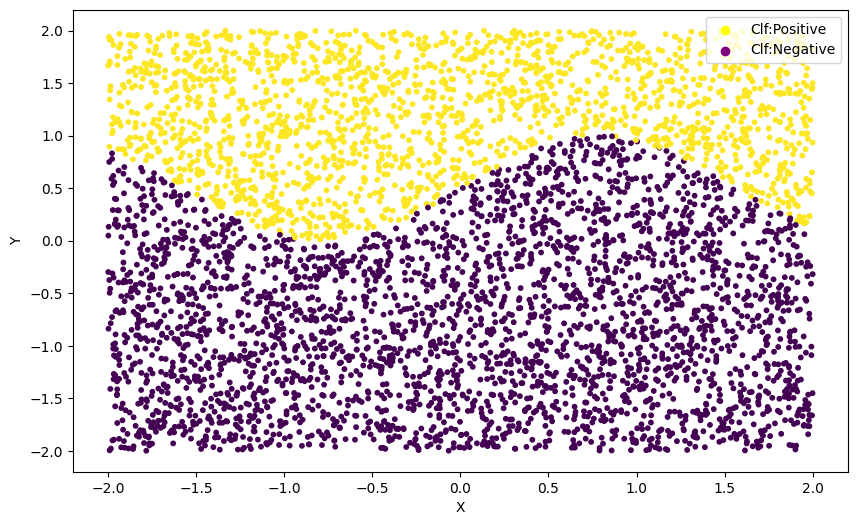

In [3]:
if True:  
    def sine_fn(x):
        return scale_labels(torch.sin(x * 2))
    

    def sine_threshold(x):
        # Create a wavy decision boundary
        threshold = sine_fn(x[:,0])
        # Second dimension is random value between -1 and 1
        # Class is 1 if random value > threshold, else 0
        return (x[:,1] > threshold).float()
    
    def linspace_2d(n_samples):
        randn_tensor = torch.rand(n_samples, 2)
        norm_tensor = (randn_tensor - randn_tensor.min()) / (randn_tensor.max() - randn_tensor.min())
        scaled_tensor = norm_tensor*4 -2
        return scaled_tensor

    
    X_clf = linspace_2d(5000)
    Y_clf = sine_threshold(X_clf)


    # Plotting the data points and the actual sine wave function
    plt.figure(figsize=(10, 6), dpi=100)

    # Scatter plot of the data points
    plt.scatter(X_clf[:, 0], X_clf[:, 1], c=Y_clf, cmap="viridis", s=10)
    plt.scatter([], [], c='yellow', label='Clf:Positive')
    plt.scatter([], [], c='purple', label='Clf:Negative')

    # Plot the actual sine wave function
    X_reg = torch.linspace(-2, 2, 1000).unsqueeze(1)
    Y_reg = sine_fn(X_reg)
    # plt.plot(X_reg.numpy(), Y_reg.numpy(), 'r-', label='Regression Problem')

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.show()

# Difference bw classification and regression 

-  **Classification**: which side of the curve are we in? 
- **Regression** what is the curve


# Understanding mean squared error

$$ \text{mean squared error}(\hat{y}, y) = \frac{(\hat{y}-y)^2}{2}$$


Lets look at what this would mean in our **curve fitting** (regression) examples

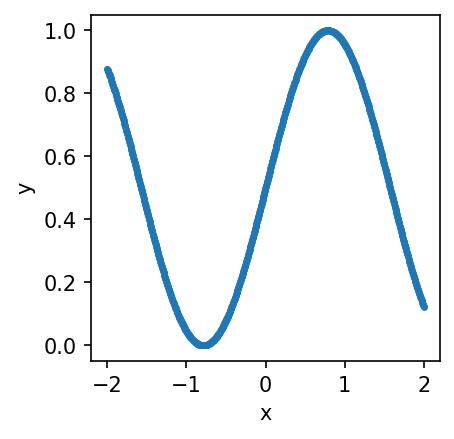

In [4]:
visualize_dataset(X_reg, Y_reg)

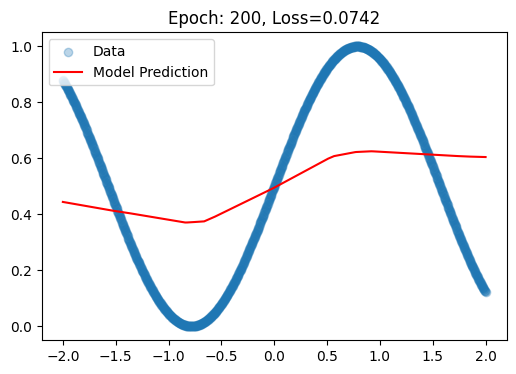

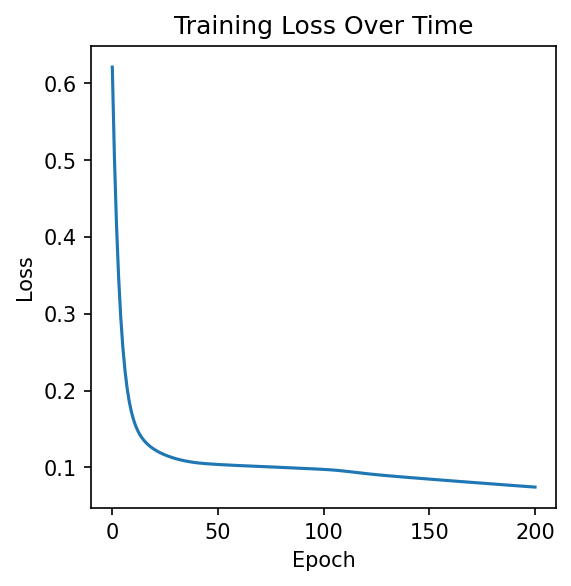

In [7]:
# Lets use our MLP as defined in prev session (just varying the input dimension also)
class MLP(torch.nn.Module):
    def __init__(self, input_dim: int = 1, n_hidden_layers: int = 5, act_fn: torch.nn.Module = torch.nn.ReLU, hidden_dim: int = 10, final_act: Callable | None = None):
        super().__init__()
        # Define the input layer
        input_layer = torch.nn.Linear(input_dim, hidden_dim)
        
        # Define the hidden layers with activation functions
        hidden_layers = [act_fn()]  # Activation over the input layer
        for _ in range(n_hidden_layers):
            hidden_layers += [torch.nn.Linear(hidden_dim, hidden_dim), act_fn()]
        
        # Define the output layer
        output_layer = torch.nn.Linear(hidden_dim, 1)

        # Combine all layers into a sequential model
        self.layers = torch.nn.Sequential(input_layer, *hidden_layers, output_layer)
        self.final_act = final_act

    def forward(self, x):
        return self.final_act(self.layers(x)) if self.final_act is not None else self.layers(x)
    
model = train(MLP(1, 2), X_reg, Y_reg, learning_rate=0.05, viz_every=10)

## MSE in this position

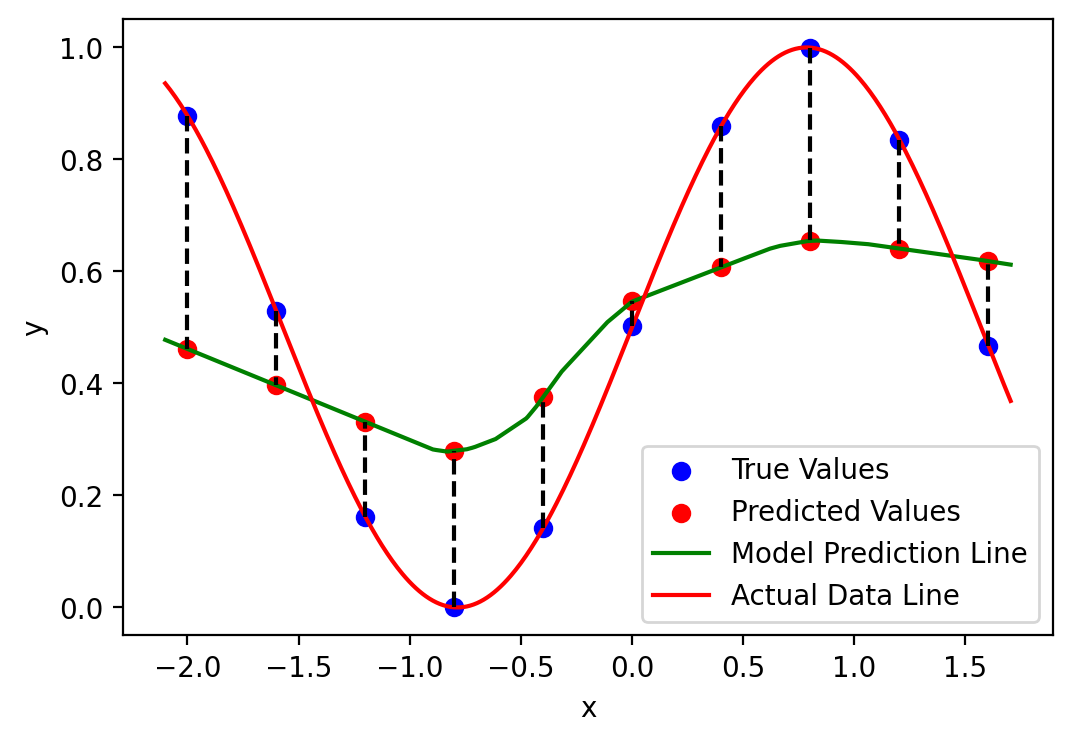

In [6]:
# The model is not doing well. But that's besides the point. Let's look at what the loss is saying.

if True:
    ## Lets take ten random points, and see
    indices = torch.randperm(X_reg.size(0))[:10]
    indices = torch.arange(0, X_reg.shape[0], X_reg.shape[0]//10)
    x_chosen = X_reg[indices]
    y_chosen = Y_reg[indices]

    ## Lets plot them
    y_pred = model(x_chosen)

    ## also doing a pred on all entire x space
    x_all = torch.linspace(x_chosen.min()-0.1, x_chosen.max()+0.1, 500).unsqueeze(1)
    y_all = model(x_all)
    y_true_all = scale_labels(sine_fn(x_all))


    ## Plotting them together, and drawing a line from y_chosen to y_pred

    plt.figure(figsize=(6, 4), dpi=200)
    plt.scatter(x_chosen.numpy(), y_chosen.numpy(), color='blue', label='True Values')
    plt.scatter(x_chosen.numpy(), y_pred.detach().numpy(), color='red', label='Predicted Values')
    plt.plot(x_all.numpy(), y_all.detach().numpy(), color='green', label='Model Prediction Line')
    plt.plot(x_all.numpy(), y_true_all.detach().numpy(), color='red', label='Actual Data Line')

    # Draw lines from y_chosen to y_pred
    for i in range(len(x_chosen)):
        plt.plot([x_chosen[i].item(), x_chosen[i].item()], [y_chosen[i].item(), y_pred[i].item()], 'k--')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()


## How far are we from the ideal position?

- take the **eucledian** distance between each y_true, y_pred point (the dotted line).

$$\begin{equation}
\begin{split}
p_1 &:= (x_1, \hat{y}_1) \\
t_1 &:= (x_1, y_1) \\ \\ \\
\text{eucledian\_distance}(p_1, t_1) &= \sqrt{(x_1 - x_1)^2 + (\hat{y}_1 - y_1)^2} \\
                                     &= \sqrt{(\hat{y}_1 - y_1)^2} \\

\\ \text{squaring both sides ...} \\
\text{eucledian\_distance\_squared}(p_1, t_1) &= (\hat{y}_1 - y_1)^2 \\
\text{eucledian\_distance\_squared}(p_1, t_1) &= \text{mean squared error}(\hat{y}, y) * 2 \\
\end{split}
\end{equation}
$$

Mean squared error is really just 'how far away is my output from the ideal output'

# Classification

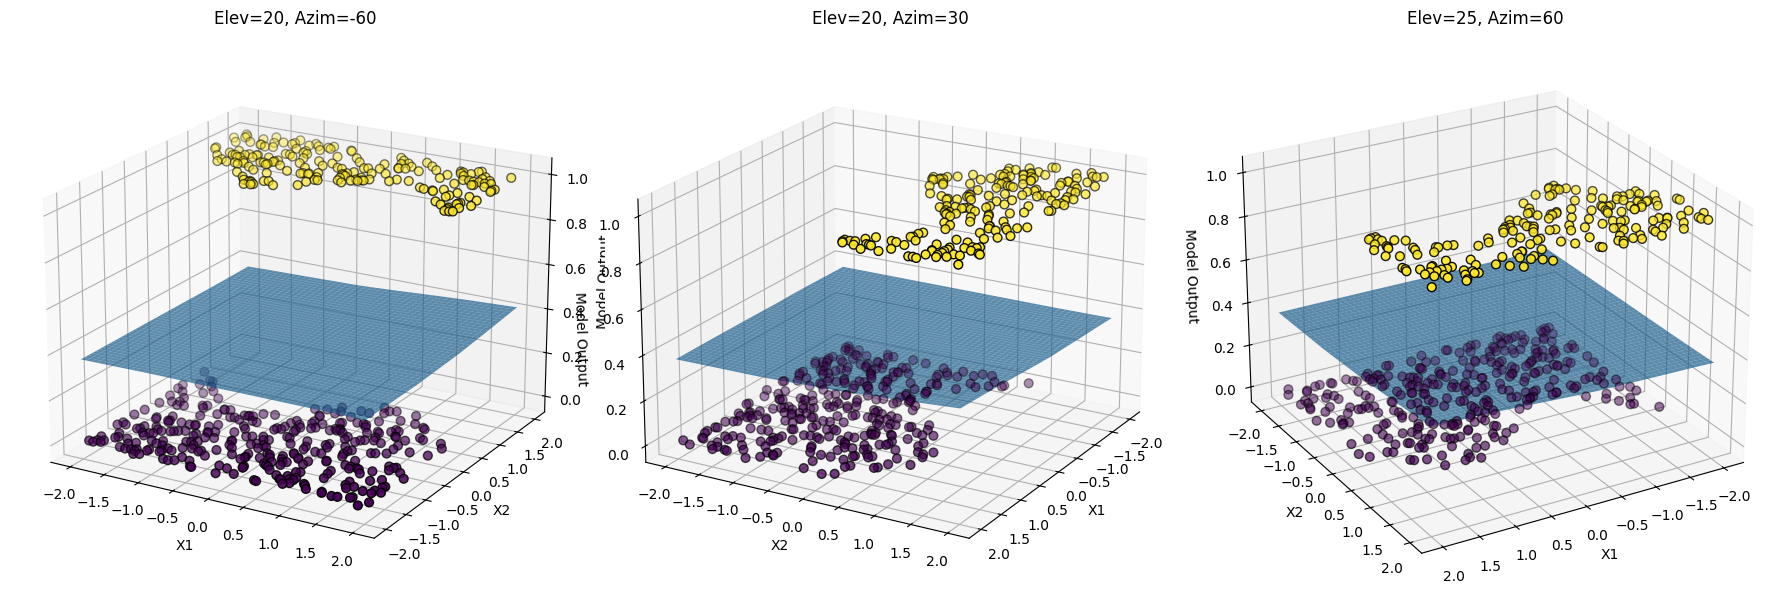

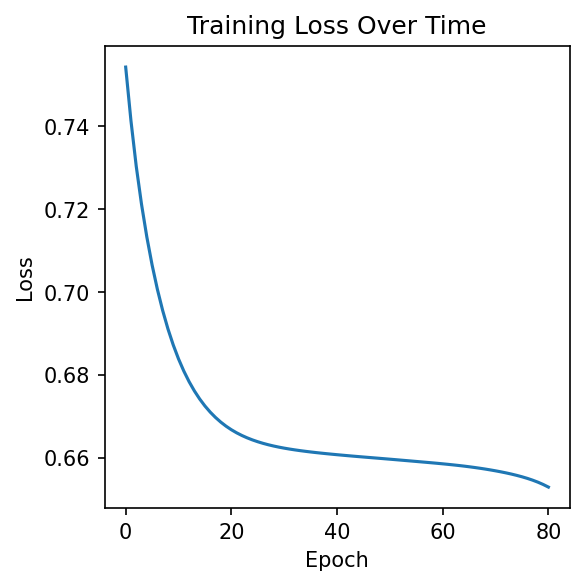

In [11]:
clf = train(MLP(2, 3, final_act=torch.sigmoid), X_clf, Y_clf.unsqueeze(1), viz_every=20, learning_rate=0.2, loss_function=torch.nn.BCELoss(), epochs=80)

# What is cross entropy loss and what does it measure?

>  for now we restrict ourself to cross entropy in binary classification setting

There's a difference between what we want in regression (curve fitting) and classification:

- In regression, we want the loss to represent *how far we are* -> MSE measures distance
- In classification, we want to *compare probabilities* -> CE measures gain in information

### So how do we measure a difference in probability?

Let's say there is a true distribution: $P$

Let's say our predictor's difference is $Q$. It is an *approximation* of $P$.



### Entropy - Uncertainty

Measures uncertainty in a distribution. 

$$ H(P) = - \sum P(x)\ \text{log}P(x) $$

- Maximum entropy (1 bit): when we have 50% class 0, 50% class 1.
- Minimum entropy (0 bit): when all examples are in the same class

-----

### Cross entropy - Mismatch

It measures the mismatch between true distribution ($P$) and our predicted distribution $Q$.

$$ H(P, Q) = - \sum P(X)\ \text{log} Q(x) $$

How to interpret this:

1. The number of "bits" needed to encode events from one distribution using the optimal code for another distribution
2. How "surprised" we would be seeing the actual outcomes given our predicted probabilities

By using (binary) cross entropy, we are directly optimizing the probability estimates themselves, not the geometric distance between numbers.

#### Practically, 

For binary cases, and given $y$ and $\hat{y}$, we have:

$$ H(y, \hat{y}) = - [ y\ \text{log}(\hat{y}) + (1-y)\ \text{log}(1-\hat{y})] $$


$$ = - log(\hat{y})


# Why Cross Entropy

## How does MSE change?

Lets say our target $y$ was 1.

What is the mean squared error for different values of $\hat{y}$?

torch.Size([500]) torch.Size([500])


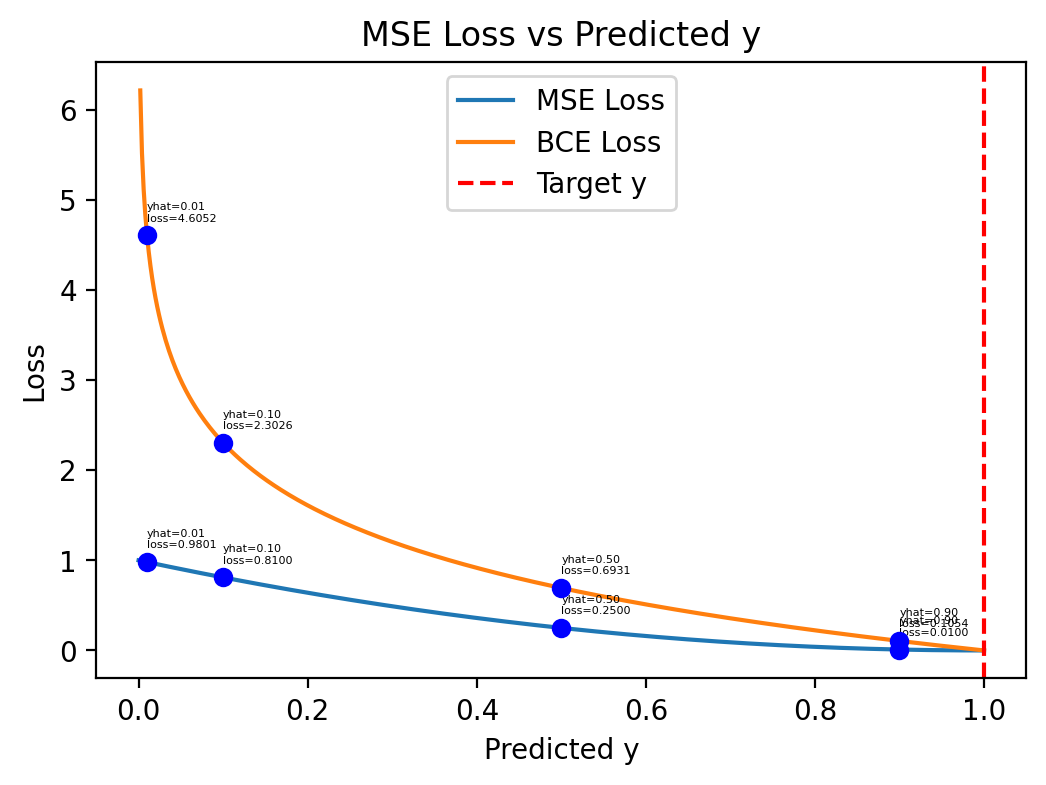

In [14]:
if True:
    target = 1
    values_of_yhat = torch.linspace(0, 1, 500)
    y_true = torch.ones_like(values_of_yhat)
    # mse = torch.nn.functional.mse_loss(y_pred, y_true)

    values_of_mse = mse_loss = (1 - values_of_yhat)**2
    values_of_bce = - torch.log(values_of_yhat)

    # Additional points
    additional_yhat = torch.tensor([0.1, 0.01, 0.5, 0.9])
    additional_mse = (1 - additional_yhat)**2
    additional_bce = -torch.log(additional_yhat)


    # Plotting loss against values of yhat.
    # Adding a straight line to represent the ytrue

    plt.figure(figsize=(6, 4), dpi=200)
    print(values_of_mse.shape, values_of_yhat.shape)
    plt.plot(values_of_yhat.numpy(), values_of_mse.numpy(), label='MSE Loss')
    plt.plot(values_of_yhat.numpy(), values_of_bce.numpy(), label='BCE Loss')
    plt.axvline(x=target, color='r', linestyle='--', label='Target y')

    # Mark additional points
    plt.scatter(additional_yhat.numpy(), additional_mse.numpy(), color='blue', zorder=5)
    for i, txt in enumerate(additional_yhat.numpy()):
        plt.annotate(f'yhat={txt:.2f}\nloss={additional_mse[i].item():.4f}', (additional_yhat[i].item(), additional_mse[i].item()), textcoords="offset points", xytext=(0,5), ha='left', fontsize=4)

    plt.scatter(additional_yhat.numpy(), additional_bce.numpy(), color='blue', zorder=5)
    for i, txt in enumerate(additional_yhat.numpy()):
        plt.annotate(f'yhat={txt:.2f}\nloss={additional_bce[i].item():.4f}', (additional_yhat[i].item(), additional_bce[i].item()), textcoords="offset points", xytext=(0,5), ha='left', fontsize=4)

    plt.xlabel('Predicted y')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('MSE Loss vs Predicted y')
    plt.show()


As we see, the penalization of Cross entropy is also extreme. For 0.1 vs 0.01, MSE loss is only about 20% more severe, but for CE, it is twice as harsh.

Cross entropy imposes a much steeper penalty when predictions are confidently wrong. The loss approaches infinity as the prediction approaches zero for a positive example, providing a stronger learning signal.


## Gradients

Remember when training with MSE, the model would go haywire quite frequently? The loss would keep on increasing and increasing? Or alternatively, the model would sometimes take foreeverrrrrrr to learn?

In the context of binary classification, let's look at the gradients.

**MSE gradient with sigmoid:**
- The gradient includes: $2(\hat{y} - y) \times \hat{y}(1-\hat{y})$
- That $\hat{y}(1-\hat{y})$ term becomes very small when predictions are close to 0 or 1
- This creates a "vanishing gradient problem"

With MSE, when prediction is very wrong (predicting 0.1 when the true value is 1), the gradient becomes small because of that $\hat{y}(1-\hat{y})$ term. This means learning happens slowest when you need it most!

**Cross entropy gradient:**
- Simplifies to just: $\hat{y} - y$
- No vanishing gradient issue

## Vibe Math

- MSE is a 'bring everything together' loss function. It has no notion of the fact that our outputs are bound between 0 and 1.
- BCE does. It emerges from information theory, and likelihood estimation. It optimizes directly for probability of the correct class